## Recursive SMARTS

In this notebook, we'll cover recursive SMARTS, a powerful technique for matching specific chemical features.  In contrast to a standard SMARTS pattern, where each atom in the pattern matches an atom in the target molecule, recursive SMARTS match a **single atom** and its surrounding environment.  As such, recursive SMARTS, are ideal when we want to assign labels to specific atoms.  As we will see below, the flexibility of recursive SMARTS also makes them helpful for several other purposes.

Install the necessary Python libraries

In [ ]:
%%capture
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage

To begin, let's define an example molecule with two different sidechains, a carboxylic acid and an aldehyde.

In [3]:
m1 = Chem.MolFromSmiles("OC(=O)c1cccc(C=O)c1")

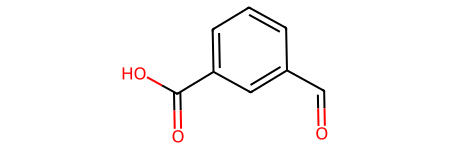

In [ ]:
m1

If we define a SMARTS for a carbxoylic acid, the pattern matches 3 heavy (non-hydrogen) atoms.  Remember that hydrogens in a SMARTS are simply specifiers for the attached heavy atom.

In [4]:
simple_acid_smarts = "C(=O)[OH]"
simple_acid_query = Chem.MolFromSmarts(simple_acid_smarts)

In [5]:
m1.GetSubstructMatches(simple_acid_query)

((1, 2, 0),)

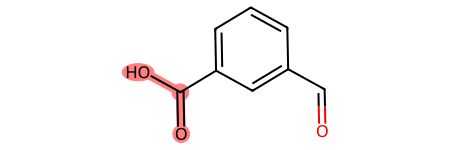

In [6]:
m1

In a recursive SMARTS, the smarts is enclosed by **\[$()\]**.  This indicates that only the first atom in the SMARTS should be matched.  Let's change the carboxylic acid SMARTS above to a recursive SMARTS.

In [7]:
recursive_acid_smarts = "[$(C(=O)[OH])]"
recursive_acid_query = Chem.MolFromSmarts(recursive_acid_smarts)

Note that the recursive SMARTS only matches one atom, the first atom in the pattern.

In [8]:
m1.GetSubstructMatches(recursive_acid_query)

((1,),)

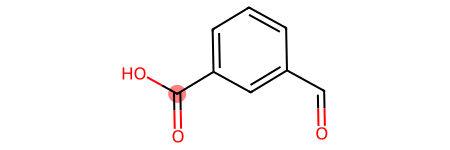

In [9]:
m1

Let's rewrite the SMARTS and make the carboxylate oxygen the first atom.  Now notice that the matched atom changes.

In [10]:
rearranged_recursive_smarts = "[$([OH]C(=O))]"
rearranged_recursive_query = Chem.MolFromSmarts(rearranged_recursive_smarts)

In [11]:
m1.GetSubstructMatches(rearranged_recursive_query)

((0,),)

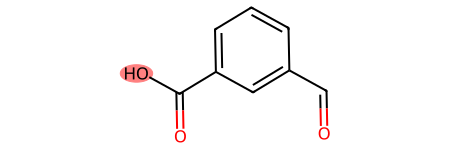

In [12]:
m1

Recursive SMARTS can also be combined to create more complex queries.  Queries can be combined with **"&"** for AND or **","** for OR.   There is also the **";"** operator, which represents AND with a lower priority than OR. In the example below, the carbonyl query below two atoms in the target molecule.

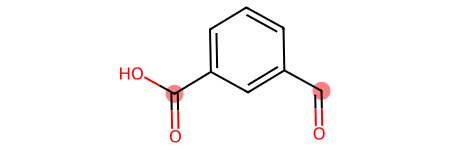

In [13]:
combo_query = Chem.MolFromSmarts("[$(C=O)]")
m1.GetSubstructMatches(combo_query)
m1

If we modify the recursive SMARTS to add another term with an AND condition **&$(\[CD3\])**, the new recursive SMARTS only matches carbonyl groups with 3 connected heavy atoms (degree 3).

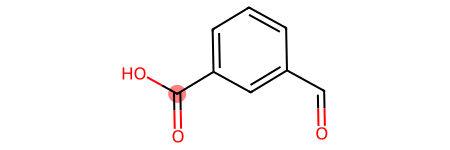

In [14]:
combo_query = Chem.MolFromSmarts("[$(C=O)&$([CD3])]")
m1.GetSubstructMatches(combo_query)
m1

Recursive SMARTS can also represent a NOT condition by specifying a **"!"** operator.  If we modify the recursive SMARTS above and chage the second part to **&!$(\[CD3\])**, the SMARTS matches carbonyl groups that **do not** have 3 connected heavy atoms.

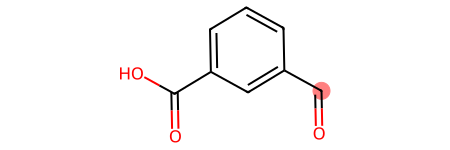

In [15]:
not_query = Chem.MolFromSmarts('[$(C=O)&!$([CD3])]')
m1.GetSubstructMatches(not_query)
m1

Recursive SMARTS also provide a convenient means of handling cases where multiple possibilities exist.  As an example consider nitro groups. Show below are three different ways of representing a nitro group.  Let's say we're designing a functional group filter and we want to be able to catch any of the three representations below.  First let's create three versions of nitrobenzene with different nitro representations.

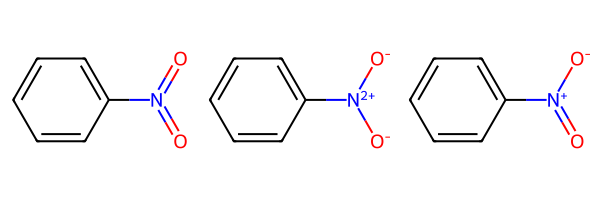

In [16]:
nitro_smi_list = ["c1ccccc1N(=O)(=O)","c1ccccc1[N+2]([O-])([O-])","c1ccccc1[N+](=O)([O-])"]
# In the following line, "sanitize = False" is used to prevent RDKit from altering the nitro groups while parsing the molecule. This allows the three different representations of the nitro group to be preserved and shown. However, the example also works without disabling sanitization.
nitro_mol_list = [Chem.MolFromSmiles(x, sanitize = False) for x in nitro_smi_list]
MolsToGridImage(nitro_mol_list)

We can then define a recursive SMARTS query which combines the three representation with a **","** representing an "or" condition.  The initial **"N;"** isn't strictly necessary, but I like writing the SMARTS this way to remind myself that I'm matching a single nitrogen.

In [17]:
nitro_query = Chem.MolFromSmarts("[N;$([N](=O)(=O)),$([N+2]([O-])([O-])),$([N+](=O)([O-]))]")

In [18]:
hal = [x.GetSubstructMatches(nitro_query)[0] for x in nitro_mol_list]

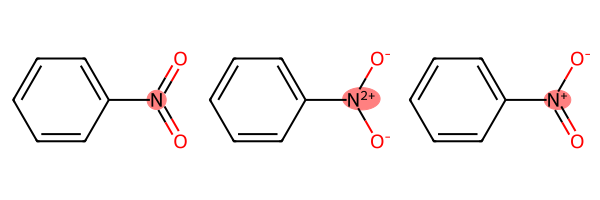

In [19]:
MolsToGridImage(nitro_mol_list, highlightAtomLists=hal)

**Core** **idea**:
Recursive SMARTS ([$(...)]) tests one atom by embedding a SMARTS subpattern that inspects its neighbors or broader environment.

**Syntax** **reminder**:
Always wrap your subpattern in [$(...)]; nothing outside those parentheses affects matching that atom.

**Context** **over** **count**:
Use recursive SMARTS when atom‑centric context matters (e.g. “this carbon only if it’s bonded to two heteroatoms”), not for mapping entire substructures.

**Minimalism**:
Keep the subpattern inside $(...) as small as will suffice—overly broad recursion hurts readability and speed.

**Atom** **index** **labeling**:
RDKit will return the index of the single atom that satisfies your recursive pattern, making it perfect for per‑atom annotations.